<a href="https://colab.research.google.com/github/BenaribIlyes/Edge_computing/blob/main/edge_computing_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travaux Pratiques - N9EE39A Edge Computing
**Contact: Adrien THIRION ([email](adrien.thirion@nanomade.com))**  
**Créé en Octobre 2023**

L'objectif de ces séances de travaux pratiques est de vous familiariser avec le métier de Data Scientists, plus particulièrement dans un environnement contraint (système embarqué). Celui-ci a été pensé pour développer une vue d'ensemble de toutes les étapes nécessaires lors de la création d'un modèle, jusqu'à ce que celui-ci soit embarqué.

Comme tout bon data scientist, l'utilisation de fonction existante sur internet est **vitale** !! En effet, l'intelligence artificielle est très présent de nos jours, donc si vous avez un problème, il est presque assuré que quelqu'un ait déjà eu le même !

Le TP va se porter sur un sujet concret: la reconnaissance vocal. Ce sujet rentre dans le thème du Traitement automatique du langage naturel ou NLP [[1]](https://en.wikipedia.org/wiki/Natural_language_processing)) où la demande en IA embarqué est très recherchée (ex. enceinte connecté, smartphone, smartwatches, ..). Pour cela, vous allez vous baser sur une base de données existante se trouvant Kaggle: the TensorFlow Speech Recognition Challenge. Kaggle est un site de competition permettant de récompenser les meilleurs modèles avec des prix décernés aux meilleurs modèles. Cette compétition a été organisée par Google, avec plus de 25 000$ à gagner. Certaines peuvent même dépasser le million de dollard (ex. Netflix Price) donc si vous avez soif d'argent ou que le l'IA vous plaît, allez y jeter un coup d'oeil !

Dans ce projet, vous allez essayer de classer correctement les 12 labels présents dans cette base de donnée via un modèle de convolution 1D ou récursif que vous aurez optimisé. Puis, vous devrez visualiser la variation des performances de ce modèle en fonction de son allégement (dans une volonté de l'embarquer).

Le Rapport devra être fait sur ce jupyter notebook, en Markdown (comme le texte que vous êtes en train de lire).

Ce projet a pour but d'évaluer votre esprit critique, votre analyse d'un problème et votre regard critique sur vos performances. Pour cela, l'entraide est encouragée mais en aucun cas le plagiat. Merci de respecter cela (promis c'est pour votre bien). Expliquez bien votre démarche et la raison de vos choix !!

Le projet sera découpé en 5 TPs de 4h. Un guide de progession sera affiché sur chaque partie pour connaître votre avancement.


Ce projet va être découpé en plusieurs parties:


1. L'Analyse de la base de donnée.
1. L'état de l'art.
1. Le Preprocessing.
1. L'apprentissage du modèle.
1. Les résultats et discussions.
1. L'allégement du modèle.
1. La conclusion.

## Analyse de la base de donnée


La première étape est de télecharger et d'analyser la base de donnée. Pour cela rendez vous sur le site de la compétition:  
https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge/overview

Pensez à bien regarder la compétition en détail, cela pourra vous être très utile (comme par exemple trouver du code ou des articles).

&nbsp;

<font color="Darkred"> Progression du TP après cette partie (environ 2h): </font>  

### Information sur la base de donnée
<font color=" Darkblue"> **Tips:** Parlez de tous ce que vous savez des données (quantité d'instances, les labels, la taille d'une time series, sa fréquence d'echantillonage, ...). </font>

Le dossier contient trois fichiers principaux :    
**- Train.7z** : Les données d'entraînement sont des enregistrements d'**une seconde**. La fréquence d'échantillonnage est de **16 KHz** . Les labels à prédire sont : **yes, no, up, down, left, right, on, off, stop, go**.

**-Test.7z** : Contient un dossier de 150,000+ fichiers au format wav.

**-Sample_submission.csv** - Un exemple de rendu.

### Visualitation d'une donnée et analyse critique
<font color=" Darkblue"> **Tips:** Faites un subplot de plusieurs labels différents pour voir visuellement les différences. </font>

> **Ecrire votre texte ici.**

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scipy.io import wavfile

from google.colab import drive # Pour google colab
drive.mount('/content/drive')  # Pour google colab


# Ajouter ce dossier dans votre drive: https://drive.google.com/drive/folders/1AAiaDTWJzvS6NaZXE_dfJ603QWhhcl0R?usp=sharing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
# Exporter une donnée
sample_rate, time_series = wavfile.read('/content/drive/MyDrive/tensorflow-speech-recognition-challenge/train/audio/bird/00b01445_nohash_0.wav')
print(f"Fréquence d'échantillonnage : {sample_rate} Hz ")

# Ecouter la donnée
ipd.Audio(time_series, rate=sample_rate)


Fréquence d'échantillonnage : 16000 Hz 


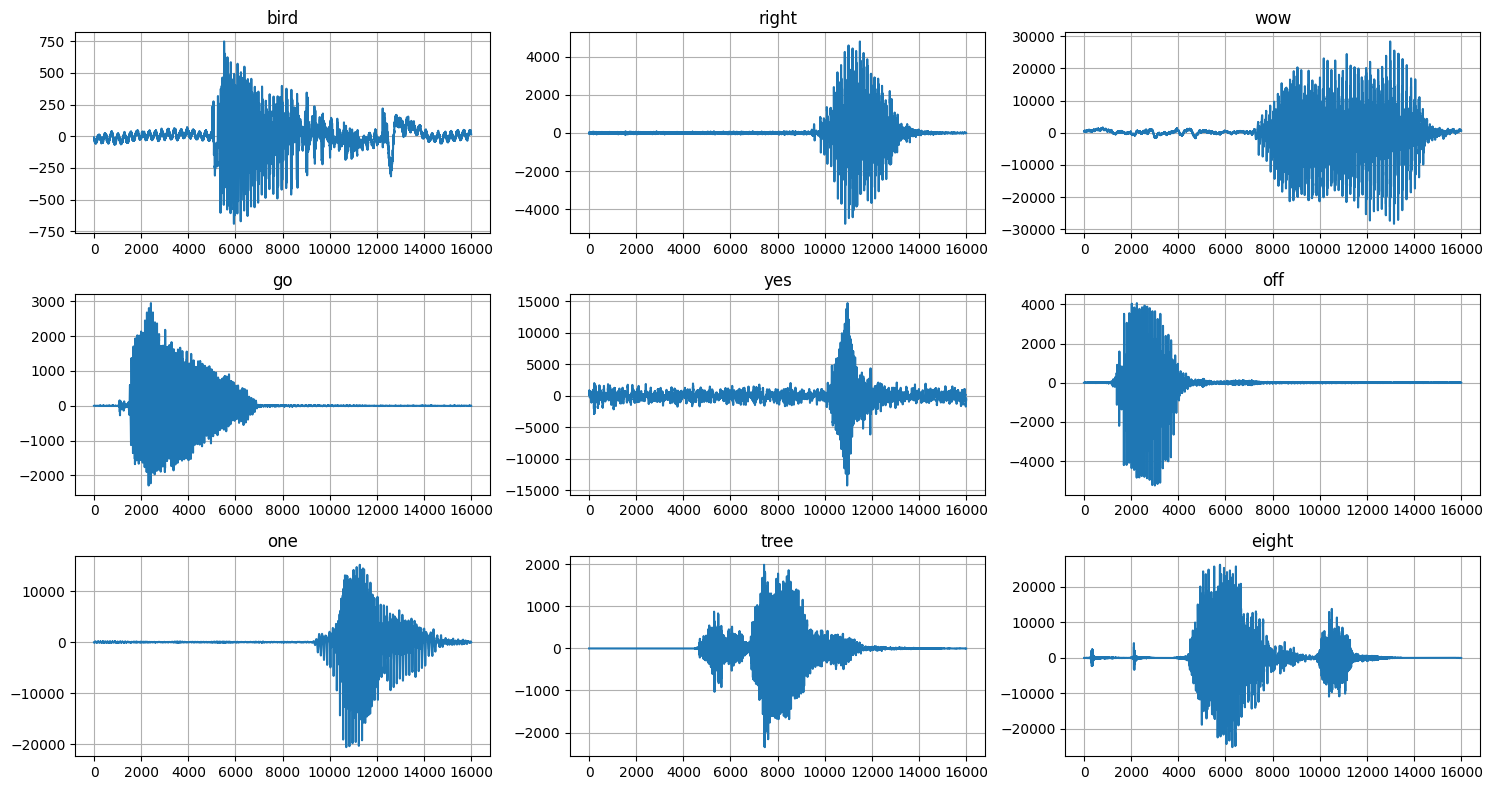

In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Chemin vers les données
Labels_path = '/content/drive/MyDrive/tensorflow-speech-recognition-challenge/train/audio/'
labels = os.listdir(Labels_path)[1:]  # On ignore le premier fichier

# Sélection aléatoire de 9 labels
Random_Labels = np.random.choice(labels, size=9, replace=False)

plt.figure(figsize=(15, 8))

for i, label in enumerate(Random_Labels, 1):
    wav_files_path = os.path.join(Labels_path, label)
    random_wav = np.random.choice(os.listdir(wav_files_path))  # un fichier wav aléatoire
    sr, time_series = wavfile.read(os.path.join(wav_files_path, random_wav))

    plt.subplot(3, 3, i)
    plt.plot(time_series)
    plt.grid()
    plt.title(label)

plt.tight_layout()
plt.show()


### Stockage des données
 <font color="red"> **ATTENTION:** Respectez l'ordre des labels: 0 = yes, 1 = no, 2 = up, 3 = down, 4 = left, 5 = right, 6 = on, 7 = off, 8 = stop, 9 = go, 10 = silence, 11 = unknown </font>

<font color=" Darkblue"> **Tips:** Réduisez la taille des données d'entrées afin d'éviter la saturation de la mémoire </font>

In [106]:
import os
import numpy as np
from scipy.io import wavfile

# Dictionnaire des labels → identifiants
Data_Dict = {
      "yes": 0,
      "no": 1,
      "up": 2,
      "down": 3,
      "left": 4,
      "right": 5,
      "on": 6,
      "off": 7,
      "stop": 8,
      "go": 9,
      "_background_noise_": 10,
      "unknown": 11
  }

def import_data(max_files_per_label= 100):
    all_waves, all_labels = [], []
    data_path = '/content/drive/MyDrive/tensorflow-speech-recognition-challenge/train/audio/'

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            continue

        label_id = Data_Dict.get(label, Data_Dict["unknown"])

        # Ne prendre que les fichiers .wav
        wav_files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
        wav_files = wav_files[:max_files_per_label]

        for wav_file in wav_files:
            file_path = os.path.join(label_path, wav_file)
            sr, samples = wavfile.read(file_path)

            # Fixer la durée à 1 seconde (16000 échantillons)
            if len(samples) > 16000:
                samples = samples[:16000]
            else:
                samples = np.pad(samples, (0, 16000 - len(samples)))

            all_waves.append(samples)
            all_labels.append(label_id)

    return np.array(all_waves), np.array(all_labels)


In [107]:
all_waves,all_labels = import_data(max_files_per_label=5)


/tmp/ipython-input-3140266934.py:38: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, samples = wavfile.read(file_path)


In [108]:
# Affichage des tailles
print(f'Taille des données : {all_waves.shape}')
print(f'Taille des labels : {all_labels.shape} \n')

# Exemple de donnée
id_exemple = 34
Exemple = [all_waves[id_exemple], all_labels[id_exemple]]
print(f"Exemple d'échantillon de données : {Exemple[0]}")
print(f"Exemple d'échantillon de label : {Exemple[1]} \n ")

# Récupérer le nom du label à partir de son ID
label_nom = [k for k, v in Data_Dict.items() if v == Exemple[1]][0]
print(f"L'exemple est un enregistrement du label : {label_nom}")

# Lecture audio
ipd.Audio(Exemple[0], rate=16000)


Taille des données : (155, 16000)
Taille des labels : (155,) 

Exemple d'échantillon de données : [101 121 101 ... 159 154 125]
Exemple d'échantillon de label : 11 
 
L'exemple est un enregistrement du label : unknown


## Etat de l'art

Etape importante qui suit: faire un état de l'art. Que cela soit pour innover, ou pour trouver une solution existante pertinente, faire un état de l'art scientifique est essentiel. Ici, vous devez chercher les articles liés à ce projet. Il faut pour cela remplir le tableau et bien marquer leurs références en dessous. De plus, un texte synthétique vous sera demandé pour expliquer selon vous, quels papiers sont les plus pertinants pour la suite de ce projet.

Attention: une analyse critique est nécessaire sur ces papiers (certain papiers peuvent avoir des biais cachés).

<font color="orange"> **Note anti-plagiat:** Au moins 2 références devraient être différente des autres binômes. </font>

&nbsp;


<font color="Darkred"> Progression du TP après cette partie (environ 2h):

&nbsp;

> **Ecrire votre texte ici.**

| References | Preprocessing | Modèle |  Solution Embarquée ? | Dataset utilisé | Performances |
| :---------------- | :------: | :----: | :----: | :----: | :----: |
| toto et al. [1]       |  -  | - | - | - | - |

#### Références:
- [1]: toto et al., .....

## Preprocessing

C'est la partie la plus importante du projet !! Même le modèle le plus performant de la terre ne pourra pas être précis sans des données d'entrées propres. De plus, il est important de réduire la quantité de données d'entrée (Décimation) afin de ne pas avoir un modèle trop lourd.

<font color=" Darkblue"> **Tips:** Commencez par un preprocessing simple, et améliorez le lorsque les modèles seront en cours d'apprentissage. </font>

Voici quelques sources qui pourront vous être utile pour faire votre code, en plus de l'état de l'art précedemment fait:
- https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98
- https://monkeylearn.com/blog/data-preprocessing/
- https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html (pour les plus expérimenté d'entre vous)

&nbsp;

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![56%](https://progress-bar.dev/56)


### Zone d'expérimentation

Ici vous êtes libre d'essayer des choses, les visualiser, avoir un regard critique sur la solution que vous décidez de prendre. Utilisez autant de cases de codes et de textes.

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def Transformations(transformer, num_points=120):
    """
    Met en évidence l'effet de 5 transformations :
     - Power Transform : rend la distribution plus normale
     - Difference Transform : stationnarise la série
     - Seasonal Transform : enlève la saisonnalité
     - Standardisation : moyenne=0, variance=1
     - Normalisation : valeurs entre 0 et 1
    """

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    if transformer == 'Power Transform':
        data = np.random.exponential(2.0, num_points)
        data_boxcox, λ = stats.boxcox(data)
        to_plot = [data, data_boxcox]
        titles = ['Raw Data', f'Power Transform (λ = {λ:.3f})']

    elif transformer == 'Difference Transform':
        t = np.arange(num_points)
        data = 0.5 * t + np.random.normal(0, 5, num_points)
        data_diff = np.diff(data, n=1)
        ax[0].plot(t, data); ax[0].set_title('Données brutes (avec tendance)')
        ax[1].plot(t[1:], data_diff); ax[1].set_title('Après différence (stationnaire)')
        for a in ax: a.grid()
        plt.show()
        return

    elif transformer == 'Seasonal Transform':
        # Série avec tendance et saisonnalité
        t = np.arange(num_points)
        period = 12
        data = 10 + 0.3*t + 5*np.sin(2*np.pi*t/period) + np.random.normal(0, 1, num_points)
        # Seasonal difference
        data_seasonal_diff = data[period:] - data[:-period]
        ax[0].plot(t, data); ax[0].set_title('Données brutes (avec saisonnalité)')
        ax[1].plot(t[period:], data_seasonal_diff); ax[1].set_title(f'Après différence saisonnière (période={period})')
        for a in ax: a.grid()
        plt.show()
        return

    elif transformer == 'Standardisation':
        data = 20 + np.sqrt(5) * np.random.normal(scale=5.0, size=(num_points, 1))
        data_trans = StandardScaler().fit_transform(data)
        to_plot = [data, data_trans]
        titles = ['Données brutes', 'Standardisées ']

    elif transformer == 'Normalisation':
        data = 20 + np.sqrt(5) * np.random.normal(scale=5.0, size=(num_points, 1))
        data_trans = MinMaxScaler().fit_transform(data)
        to_plot = [data, data_trans]
        titles = ['Données brutes', 'Normalisées [0,1]']

    else:
        raise ValueError("Transformer doit être l’un des suivants : "
                         "'Power Transform', 'Difference Transform', 'Seasonal Transform', 'Standardisation', 'Normalisation'.")

    # Affichage commun (histogrammes)
    for i, (d, title) in enumerate(zip(to_plot, titles)):
        ax[i].hist(d, bins=30, edgecolor='black')
        ax[i].set_title(title)
        ax[i].set_xlabel('Valeur')
        ax[i].set_ylabel('Fréquence')
        ax[i].grid()

    plt.tight_layout()
    plt.show()


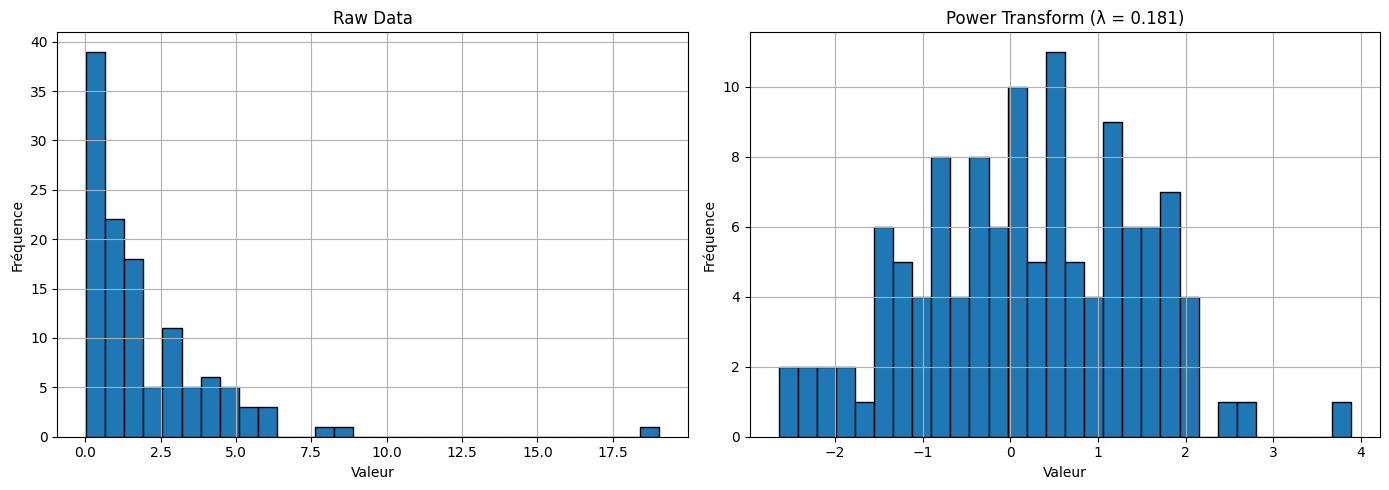

In [119]:
# Décommenter pour tester la transformation

#Transformations('Power Transform')
#Transformations('Difference Transform')
#Transformations('Seasonal Transform')
#Transformations('Standardisation')
#Transformations('Normalisation')

**PS** : En général, l'ordre à suivre pour faire du preprocessing avec ces fonctions est : Power Transform, Seasonal Difference, Trend Difference,Standardization, Normalization.

### Fonction de preprocessing

> **Ecrire votre texte ici.**

In [ ]:
def preprocessing(inputs):
    clean_inputs = inputs

    # TO DO

    return clean_inputs

all_waves = np.ones((1, 1)) # à effacer

print(f'Input before preprocessing: {all_waves.shape}')
print(f'Input after preprocessing: {preprocessing(all_waves).shape}')

## Apprentissage du Modèle
On y est, il est temps de créer un modèle. Pour cela, il vous sera imposé d'utiliser un réseau de convolution 1D [2] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Nous préconisons l'utilisation de Tensorflow mais vous êtes libre d'utiliser d'autres librairies comme Pytorch.

&nbsp;

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![75%](https://progress-bar.dev/75)

### Train set, Validation set

Avant d'entraîner votre modèle, pensez à séparer vos données d'entraînements et vos données de validations. Puis, pensez à créer des batchs pour correspondre à l'entrée de votre modèle.

Plus d'infos ici:
 - https://www.tensorflow.org/datasets/splits?hl=fr
 - https://towardsdatascience.com/how-to-split-a-dataframe-into-train-and-test-set-with-python-eaa1630ca7b3
 - https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough?hl=fr

 <font color=" Darkblue"> **Tips:** Pensez à bien mélanger vos données avant de les séparer. </font>

 <font color="orange"> **Note anti-plagiat:** Le mélange doit avoir une random seed fixe et différente pour chaque groupe. </font>

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


# TO DO: Séparez vos données.
X_train, y_train = np.random.rand(100, 1000), np.random.randint(0, high=12, size=100) # à effacer
X_val, y_val = np.random.rand(100, 1000), np.random.randint(0, high=12, size=100) # à effacer

y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=12)

BATCH_SIZE = 32 #Vous pouvez le modifier

X_train = np.expand_dims(X_train, axis=2)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.batch(32, drop_remainder=True)

X_val = np.expand_dims(X_val, axis=2)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val = val.batch(32, drop_remainder=True)


for example_inputs, example_labels in train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

### Baseline

La baseline est importante afin de connaître le seuil où le modèle est performant. A vous de trouver la meilleure baseline et d'expliquer votre choix.

Plus d'infos ici:
https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

> **Ecrire votre texte ici.**

In [ ]:
# TO DO

result_train, result_val = 0, 0 # à effacer

print(f'Train dataset: {result_train}%')
print(f'Validation dataset: {result_val}%')

### Modèle

Vous devez créer une fonction permettant de générer le modèle. Celle-ci doit pouvoir être modifiable en fonction des Hyperparamètres mis en entrée.

 <font color="red"> **ATTENTION:** Une limite de 150 000 paramètres est imposés. </font>

Justification de vos choix (Choix des paramètres modifiables, fonction d'activations, nombres de couches, regularizers, ...) :
> **Ecrire votre texte ici.**

In [ ]:
def total_param(model):
# Ne pas modifier.
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  for line in stringlist[::-1]:
    if "Total params" in line:
      value = line.split('(')[1]
      if value[-3:-1] == 'KB':
        return float(value[:-4]) * 1e3
      else:
        return float(value[:-4]) * 1e6


def create_model(param):
  # Exemple à modifier
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv1D(8, 100, strides=10, activation=param['activation'], input_shape=(1000,1)))
  model.add(tf.keras.layers.Flatten())
  for i in range(param['hidden_layer']):
    model.add(tf.keras.layers.Dense(200, activation=param['activation']))
  model.add(tf.keras.layers.Dense(12, activation='softmax'))
  return model

param = {
    # Exemple de paramètres à modifier
    'activation' : 'relu',
    'hidden_layer' : 1}

model = create_model(param)

model.summary()
print(f'Poids du modèle: {total_param(model)} octets')

### Fonction d'entraînement

Cette fonction doit prendre un modèle en entrée et l'entrainer grâce au Train set. Puis, retourner les performances obtenues avec le Validation set.

Pour les plus expérimentés d'entre vous: Vous pouvez réaliser une cross validation [[2]](https://datascientest.com/cross-validation).

Justification de vos choix (Choix des paramètres modifiables, optimizer, nombres d'epoch, learning rate, ...) :
> **Ecrire votre texte ici.**

In [ ]:
def compile_and_fit(model, train, val, param, verbose=1):
    # Exemple à modifier
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=0.2,
                                                    mode='min')

    # Pour les plus confirmés
    # lr = tf.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1e-2,
    #     decay_steps=1000,
    #     decay_rate=0.95)

    lr =  1e-3

    model.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    model.fit(train, epochs=param['max_epochs'],
                      validation_data=val,
                      callbacks=[early_stopping], verbose=verbose)

    validation_accuracy = model.evaluate(val)
    return validation_accuracy, model

param = {
    # Exemple de paramètres à modifier
    'max_epochs' : 1000
}

validation_accuracy = compile_and_fit(model, train, val, param)

### Fit tuning des hyperparamètres.

Après avoir défini les hyperparamètres modifiables et vérifier que les fonctions fonctionnent, il est temps de lancer l'optimisation des hyperparamètres. Pour cela je vous invite à utiliser Optuna [[3]](https://optuna.readthedocs.io/en/stable/index.html) qui a plusieurs fonctionnalités:
*   Une visualisation facilitée.
*   Un suivi de l'avancement de l'optimisation.
*   Une possibilité de reprendre l'optimisation sans reprendre depuis le début si un problème arrive durant le traitement.

 <font color=" Darkblue"> **Tips:** Essayez de lancer l'optimisation pendant le TP pour voir si il fonctionne et arretez le. Lancez le pour de bon à la fin de la séance ou pendant la semaine car cela va prendre plusieurs heures, voir plusieurs jours. </font>

 <font color="orange"> **Note anti-plagiat:** L'optimisation doit avoir une random seed fixe et différente pour chaque groupe. </font>

 Merci de justifier vos plages de valeurs et faite un résumé sous forme de tableau :
 > **Ecrire votre texte ici.**


 | Hyperparamètre | Meilleure valeur | Plage | Step | Type de la plage |
| :---------------- | :------: | :----: | :----: | :----: |
| -   |  -  | - | - | - |

In [ ]:
!pip install optuna

import optuna

SEED = 5
np.random.seed(SEED)

def objective(trial):

    # Exemple de paramètres à modifier
    param_model = {
        'activation': trial.suggest_categorical("activation", ["relu", "selu"]),
        'hidden_layer' : trial.suggest_int('hidden_layer', 1, 3)
    }

    param_training = {
        'max_epochs': trial.suggest_int('max_epochs', 800, 1000, step=100),
    }

    model = create_model(param_model)

    metrics, _ = compile_and_fit(model, train, val, param_training, verbose=0)

    trial.set_user_attr('Size', total_param(model))

    return metrics[1]


study_name = "NOM1~NOM2-Tuning"
storage_name = f'sqlite:////content/drive/MyDrive/TP N9EE39A/{study_name}.db' #Chemin à créer dans votre drive

study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    load_if_exists=True)

study.optimize(objective, n_trials=2)

## Résultat et discussion

<font color=" Darkred"> Progression du TP après cette partie (environ 3h): </font>  
![84%](https://progress-bar.dev/84)


### Export du modèle

Merci d'exporter le meilleur modèle et l'envoyer avec le jupyter notebook et la base de données d'entraînement. Lors de l'exportation d'un modèle, il est recommandé d'utiliser la base de donnée d'entrainement, et de validation.

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

In [ ]:
import joblib

study = optuna.load_study(storage=storage_name, study_name=study_name)
print("Best trial until now:")
print("   Value: ", study.best_trial.value)
print("   Params: ")
for key, value in study.best_trial.params.items():
    print(f"    -{key}: {value}")
print("----------------------")

model = create_model(study.best_trial.params)

train_and_val = tf.data.Dataset.from_tensor_slices((np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val))))
train_and_val = train_and_val.shuffle(1500, reshuffle_each_iteration=True)
train_and_val = train_and_val.batch(32, drop_remainder=True)


_, global_model = compile_and_fit(model, train_and_val, val, study.best_trial.params, verbose=0)

joblib.dump(global_model, '/content/drive/MyDrive/TP N9EE39A/NOM1~NOM2_model.pkl')

### Dépôt sur Kaggle

Il est temps de soumettre vos résultats sur Kaggle. Qu'en pensez vous, êtes vous satisfait de vos performances ? Est-ce que vous vous attendiez à ces performances ?

 <font color=" Darkblue"> **Tips:** Le format d'envoie et des tutoriels sont disponibles sur la page du concours. </font>

 <font color="orange"> **Note anti-plagiat:** Il est impossible que le fichier que vous allez déposer soit le même qu'un autre binôme. Le fichier sera regénérer lors de la correction et doit être similaire avec celui déposé. </font>

A la fin du projet, merci d'envoyer avec les autres fichiers ce fichier Kaggle avec comme nom **NOM1~NOM2_submission.csv**.

> **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet et sur le site de la compétition !

### Visualisation des résultats

Ici tous le code a déjà été fait. Il faut par contre commenter les résultats et les performances que vous avez obtenu et l'utilité de chaque figure.

 #### Matrice de confusion

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

study = optuna.load_study(storage=storage_name, study_name=study_name)
model = create_model(study.best_trial.params)
_, model = compile_and_fit(model, train, val, study.best_trial.params, verbose=0)

y_prob= model.predict(val)
y_pred = y_prob.argmax(axis=1)

ds_labels=[]
for images, labels in val.unbatch():
    ds_labels.append(labels)
y_ref = np.array(ds_labels).argmax(axis=1)

label_names = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
ConfusionMatrixDisplay.from_predictions(y_ref, y_pred, cmap='Blues', normalize='true', ax=plt.subplots(figsize=(12,12))[1], display_labels=label_names)

#### Résultat du Fit-tuning

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_optimization_history(study)

In [ ]:
plt.figure(figsize=(12,12))
optuna.visualization.plot_slice(study)

#### Influence des hyperparamètres sur les performances

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study)
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())

plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Influence des hyperparamètres sur le temps de calcul

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
result = optuna.importance.get_param_importances(study, target=lambda t: t.duration.total_seconds())
plt.figure(figsize=(12, 4.5), dpi=100)
names = list(result.keys())
values = list(result.values())

plt.bar(range(len(result)), np.array(values)*100, tick_label=names, color='#000233')
plt.ylabel("Hyperparameter importance (%)")
plt.show()

#### Frontière de Pareto [[4]](https://fr.wikipedia.org/wiki/Optimum_de_Pareto)

 <font color="green">*Cette partie du code est complète, vous n'avez pas besoin de la modifier.* </font>

 > **Ecrire votre texte ici.**

In [ ]:
import pandas

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
  # From https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y)
    plt.xlabel("Poids du modèle (octets)")
    plt.ylabel("Accuracy (%)")
    plt.show()

df = study.trials_dataframe()
plot_pareto_frontier(df['user_attrs_Size'], df['value'])

## Allégement du modèle post-optimisation

Dans cette dernière partie, nous allons nous intéresser à l'influence des performances lorsque le modèle est allégé. Dans des appareils embarqués, il est nécessaire de trouver un compromis entre la performance du modèle, son poids, et la quantité d'opération.

Au vue du nombre de séances, nous allons nous intéressé ici qu'au poids du système.

Pour cela, vous allez essayé de réduire le poids du meilleur modèle obtenu, puis avoir un regard critique sur les performances à chaque modification.

Voici les techniques d'allégement à essayer:
  - **La quantification**: Réduire le nombre d'octets des paramètres du modèles et les convertir en entiers [[5]](https://www.tensorflow.org/lite/performance/post_training_quantization).
  - **L'élagage**: Supprimer les modèles qui ont un impact mineur sur les prédictions [[6]](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras).
  - **Le clustering**: Regrouper les poids de chaque couche dans un modèle en un nombre prédéfini de clusters, puis en partageant les valeurs centroïdes pour les poids appartenant à chaque cluster individuel [[7]](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example).
  - **La décimation** : Réduire le nombre d'entrée.

<font color=" Darkred"> Progression du TP après cette partie (environ 4h):

Essayez d'avoir la meilleure accuracy avec un poids maximum inférieur à 75 KB.

 <font color=" Darkblue"> **Tips:**  Des tutoriels sont disponibles sur les liens attachés au techniques d'allégement. </font>

 > **Ecrire votre texte ici.**

In [ ]:
#Ici, tous le code est à faire. Normalement, tous a déjà été codé ou est facilement trouvable sur internet !

### BONUS: Allégement avant optimisation

Relancez un fit-tuning en rajoutant les paramètres d'allégements. Puis, observez les resultats avec une frontière de pareto. Les valeurs minimums de poids de la frontière doivent se trouver en dessous de 50 KB.

 <font color=" Darkblue"> **Tips:** Utilisez 2 métriques lorsque vous lancez la fonction d'activation. </font>

 > **Ecrire votre texte ici.**

## Conclusion


 <font color=" Darkblue"> **Tips:** Concluez sur vos résultats, les limitations de votre modèle et les perspectives envisagées pour l'améliorer. </font>


 <font color=" Darkred"> Progression du TP après cette partie (environ 0h30): </font>  


> **Ecrire votre texte ici.**